In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qibo import set_backend
set_backend("numpy")

## Grover's Algorithm

Grover’s algorithm is a **quantum search algorithm** that can search for a value or element
in an unsorted set in $\mathcal{O}(\sqrt{N})$ as opposed to classical search algorithms that at worst
will find an element in $\mathcal{O}(N)$ time.

The problem is formulated as follows:

### Problem formulation
Suppose that we are given a Boolean function
$$ f : \{ 0,1 \}^n \rightarrow  \{ 0,1 \}$$
and we wish to determine a bitstring $x$ such that $f(x) = 1$.

*Basically we want to search a specific bitstring in the ensemble for all possible bistrings.*

We can model this situation by sypposing that have the following black box:

$$ f_w (x) = \begin{cases} 0 \quad x \neq w \\ 1 \quad x = w\end{cases}$$ 

where $x \in \{ 0,1,2, \dots, N-1\} $ for some unknown $w$.


How many times do we need to query the box classically to find $w$?

*Put your answer here*

We will show that with Grover's algorithm it is possible to find the solution in $\mathcal{O}(\sqrt{N})$.

### Grover explanation

Suppose that we have a quantum **oracle** with the ability to *recognize* the element $w$. To be able to show the solution
in QC we often use ancilla/oracle qubits. A general oracle can be written as an unitary operator $O$ acting in the following way:

$$\ket{x}\ket{q} \rightarrow \ket{x}\ket{q \oplus f_w(x)}$$
where $\ket{x}$ is the index register, $\ket{q}$ is the oracle qubit and $\oplus$ is the addition modulo 2.

From the previous equation we can see how the sign of $\ket{q}$ is flipped if $f(x) = 1$. In fact:
$$ \ket{x}\ket{q \oplus f_w(w)} = \ket{x}\ket{q \oplus 1} = \ket{x} \otimes X\ket{q}$$
while if $x$ is not the solution we get the same state:
$$  \ket{x}\ket{q \oplus f_w(x)} = \ket{x}\ket{q \oplus 0} = \ket{x}\ket{q} $$



### Procedure

The first step of Grover's algorithm is to prepare the uniform superposition of all values of $x$.
### <font color='blue'>Exercise I</font>
Prepare the first step of Grover's algorithm

In [ ]:
from qibo import models, gates
def create_superposition(nqubits):
    """Create circuit for superposition"""
    superposition = models.Circuit(nqubits)
    superposition.add([gates.H(i) for i in range(nqubits)])
    return superposition

As we can see now all bistrings have equal probabilities of being sampled:

In [ ]:
nqubits = 4
superposition = create_superposition(nqubits)
result = superposition()


In [ ]:
def plot_amplitudes(amplitudes):
    """Plot amplitudes of the quantum circuit"""
    amplitudes = amplitudes.state()
    states = []
    for i in range(int(len(amplitudes))):
        states.append("{0:0{bits}b}".format(i, bits=int(np.log2(len(amplitudes)/2))))
    fig = plt.figure(figsize = (18,6))
    width = 0.5
    plt.title('Amplitudes', fontdict={'fontsize': 14})
    plt.xlabel('state', fontsize=14)
    plt.ylabel('magnitude', fontsize=14)
    plt.ylim(-1.1,1.1)
    plt.bar(states, np.real(amplitudes), color='C0', width=width)
    plt.xticks(list(range(len(states))), states, rotation=90)
    plt.grid()
    plt.show()

plot_amplitudes(result)

Grover's algorithm aims at finding the marked state by increasing its amplitude while suppressing the others.
The amplitude is increased sequentially by applying iteratively the Grover operator $G$ which is defined in the following way:

$$ G_w = O_w D$$
where $O$ is the oracle and $D$ is the diffuser.

### The oracle $O$
The oracle is the operator that changes the sign of the amplitudes of the quantum states that encode solutions of the problem.
As we saw before it corresponds to the following operation:
$$O_w: \ket{x}\ket{q} = \ket{x}\ket{q \oplus f_w(x)} .$$


By choosing $\ket{-}=\frac{\ket{0}-\ket{1}}{\sqrt{2}}$ as the initial state for the ancilla qubit we can rewrite the oracle as a *phase oracle*
$$O_w: \ket{x}\ket{-} = (-)^{f_w(x)}\ket{x}\ket{-} ,$$


which can be expressed as the following (ignoring the output register which remains $\ket{-}$):

$$ O_w = I - 2 \ket{w} \bra{w}$$
which is exactly the operator which flips $\ket{w}$.


### <font color='blue'>Exercise II</font>
Code the oracle circuit.

*Hint start with a fixed number of qubits and a specific $w$* then generalize to arbitrary $w$ and arbitrary number of qubits.

In [ ]:
def create_oracle(state):
    """Oracle"""
    nqubits = len(state)
    oracle = models.Circuit(nqubits+1)
    oracle.add(gates.X(nqubits))
    oracle.add(gates.H(nqubits))
    index = [i for i,value in enumerate(list(state)) if value == '0']
    oracle.add([gates.X(i) for i in index])
    oracle.add(gates.X(nqubits).controlled_by(*range(nqubits)))
    oracle.add([gates.X(i) for i in index])

    return oracle

Note the use of `gate.controlled_by` method which allows to control any gate to an arbitrary number of qubits

In [ ]:
oracle = create_oracle('0101')
print(oracle.draw())

Lets check again the final amplitudes after creating the superposition and applying the oracle. 

First we create the total circuit

In [ ]:
circuit = models.Circuit(nqubits+1)
circuit.add(superposition.on_qubits(*range(nqubits)))
circuit += oracle

In [ ]:
print(circuit.draw())
result = circuit()

In [ ]:
def plot_amplitudes_ancilla(amplitudes):
    """Plot amplitudes of the quantum circuit"""
    amplitudes = amplitudes.state()
    states = []
    amp = []
    for i in range(len(amplitudes)//2):
        states.append("{0:0{bits}b}".format(i, bits=int(np.log2(len(amplitudes)//2))))
    for i in range(0, len(amplitudes), 2):
        amp.append((1/np.sqrt(2))*(np.real(amplitudes[i])-np.real(amplitudes[i+1])))
    fig = plt.figure(figsize = (18,6))
    width = 0.5
    plt.title('Amplitudes', fontdict={'fontsize': 14})
    plt.xlabel('state', fontsize=14)
    plt.ylabel('magnitude', fontsize=14)
    plt.ylim(-1.1,1.1)
    plt.bar(states, amp, color='C0', width=width)
    plt.xticks(list(range(len(states))), states, rotation=90)
    plt.grid()
    plt.show()

In [ ]:
plot_amplitudes_ancilla(result)

Notice how the oracle inverted the sign of the amplitude of the target state.

### The diffuser $D$

The diffuser increase the amplitude of the marked state while lowering the other ones.
Mathematically corresponds to the following operator:

$$D = 2 \ket{s} \bra{s} - I$$
where $\ket{s} = H^{\otimes n} \ket{0}$.



###  <font color='blue'>Exercise III</font>

Implement the $D$ operator.

*Hint: $D$ can be decomposed in the following way:*
$$ D = H^{\otimes n} CPS_0 H^{\otimes n}$$
*where $CPS_0$ is a conditional phase shift that flips the sign of all amplitudes but the state $\ket{0}$*
$$ CPS_0 \ket{x} \rightarrow - (-)^{\delta_{x0}} \ket{x} $$ 

In [ ]:
def create_diffuser(nqubits):
    diffuser = models.Circuit(nqubits)
    for i in range(nqubits):
        diffuser.add(gates.H(i))
    for i in range(nqubits):
        diffuser.add(gates.X(i))
    diffuser.add(gates.Z(0).controlled_by(*range(1,nqubits)))
    for i in range(nqubits):
        diffuser.add(gates.X(i))
    for i in range(nqubits):
        diffuser.add(gates.H(i))
    return diffuser

Let's check the amplitudes after the diffusion using the same methods as above

In [ ]:
diffuser = create_diffuser(nqubits)
print(diffuser.draw())

In [ ]:
grover = models.Circuit(nqubits+1)
grover.add(superposition.on_qubits(*range(nqubits)))
grover += create_oracle('0101')
grover.add(diffuser.on_qubits(*range(nqubits)))
print(grover.draw())

In [ ]:
result = grover()
plot_amplitudes_ancilla(result)

Notice how the diffuser increased the amplitude of the target state.

### Grover's algorithm

By combining all the previous elements we can construct the full Grover's algorithm

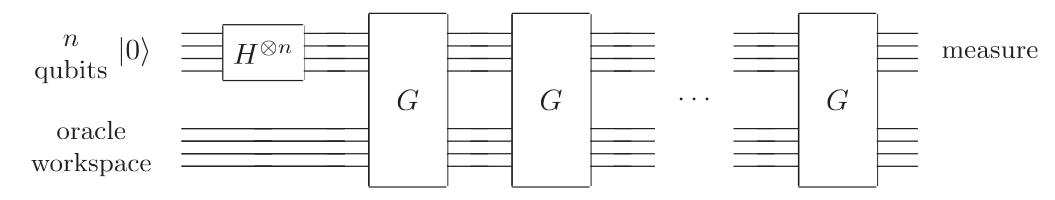

### <font color='blue'>Exercise IV: implement Grover's algorithm</font>

In [ ]:
def create_grover(state, iterations):
    """Complete circuit that implements Grover's algorithm.
    
    Args:
        state (str): Target state.
        iterations (int): Number of times the oracle + diffuser operation is repeated.
    """
    nqubits = len(state)
    superposition = create_superposition(nqubits)
    oracle = create_oracle(state)
    diffuser = create_diffuser(nqubits)
    
    grover = models.Circuit(nqubits+1)
    grover.add(superposition.on_qubits(*range(nqubits)))
    for _ in range(iterations):
        grover += oracle
        grover.add(diffuser.on_qubits(*range(nqubits)))
    # measure all qubits
    grover.add([ gates.M(i) for i in range(nqubits)])
    return grover

You can check how the amplitude is affected by changing the number of iterations below

In [ ]:
grover = create_grover('10001', 8)
plot_amplitudes_ancilla(grover())

The number of iterations that gives the highest probability $\bar{k}$ for a single solution is given by [[1]](https://arxiv.org/pdf/quant-ph/9605043.pdf)

$$ \bar{k} = \frac{\pi }{4}\sqrt{2^{n_{qubits}}} \sim \mathcal{O}(\sqrt{N})$$

where $n_{solutions}$ is the number of target solutions to the search. In our case $n_{solutions} = 1$.


## Geometric interpretation [2]

To understand the previous result it is helpful to visualize Grover's algorithm in a geometric fashion.

Firstly we can observe that a uniform superposition state $\ket{s}$ can be rewritten in the following way:

$$ \ket{s} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x} = \cos{\theta} \ket{w^\bot} + \sin\theta \ket{w}, $$
where $\ket{w}$ is the solution and $\ket{w^\bot}$ is a uniform superposition on the vector space orthogonal to $\ket{w}$.

The action of the oracle $O_w$ on $\ket{s}$ is the following:

$$ O_w \ket{s} = (I - 2 \ket{w} \bra{w}) ( \cos{\theta}  \ket{w^\bot} + \sin\theta \ket{w}) $$
$$ \begin{split}
O_w \ket{s} & = (I - 2 \ket{w} \bra{w}) ( \cos{\theta}  \ket{w^\bot} + \sin\theta \ket{w}) \\
& = \cos{\theta}  \ket{w^\bot} + \sin\theta \ket{w} - 2 \sin\theta \ket{w} \\
& = \cos{\theta}  \ket{w^\bot}  - \sin\theta \ket{w} ,
\end{split}$$
which is a *reflection around $\ket{w}$*.

The action of the d}}}{iffuser on the state produced by the oracle is the following:

$$ \begin{split} 
D O_w \ket{s} &= \big[2 \ket{s}\bra{s} - I \big]O_w \ket{s} = \big[ 2 \ket{s}\bra{s}  - I \big] (\cos{\theta}  \ket{w^\bot}  - \sin\theta \ket{w}) = \\
& = 2 \ket{s} (\cos^2 \theta - \sin^2 \theta) - \cos{\theta}  \ket{w^\bot}  + \sin\theta \ket{w} \\
& = \underbrace{(4 \cos^3 \theta - 3 \cos \theta)}_{\cos 3 \theta} \ket{w^\bot} + \underbrace{( 3 \sin\theta - 4 \sin^3 \theta)}_{\sin 3 \theta} \ket{w} .
\end{split}$$
Therefore we have shown that a single action of the Grover operator $G$ corresponds to the following transformation:
$$ \cos \theta \ket{w^\bot} + \sin \theta \ket{w} \xmapsto{G_w} \cos 3 \theta \ket{w^\bot} + \sin 3 \theta \ket{w} $$
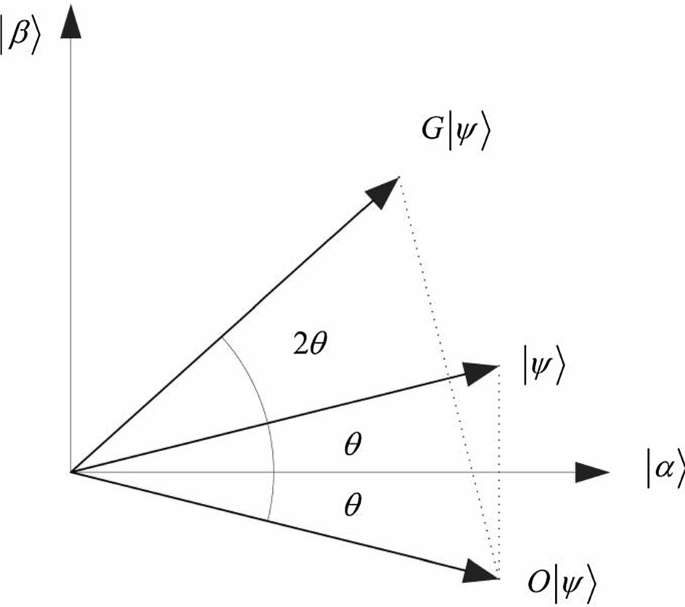
</div>
The continued application of $G_w$ results in 

$$ G^m_w \ket{s} = \cos (2k+1)\theta \ket{w^\bot} + \sin (2k+1) \theta \ket{w}$$

to find the solution we need to impose $(2k+1)\theta = \pi / 2$ and we can recover that the number of iterations that yields the highest probability is $\bar{k} \sim \mathcal{O}(\sqrt{N})$.


In [ ]:
def grover_iterations(nqubits, nsol=1):
    return int((np.pi/4)*np.sqrt((2**nqubits)/nsol))

In [ ]:
iterations = grover_iterations(3)
iterations

In [ ]:
grover = create_grover('101', iterations)
plot_amplitudes(grover())

We can also have a look at the frequencies of measuring each bitstring

In [ ]:
result = grover(nshots=1000)
result.frequencies()

## Let's try to run the Grover's algorithm with an increasing number of qubits?

How does the perfomance decreases computational wise with a large number of qubits?

In [ ]:
import time

def performance(input: dict, qubit_range=range(4,15)):
    """Simple function to compare Grover's performance on
    different qibo backends"""
    
    results = {}
    for label, backend_platform in input.items():
        set_backend(*backend_platform.split("-"))
        times = []
        for i in qubit_range:
            iterations = grover_iterations(i,1)
            print(f"Executing grover with {label} on {i} qubits")
            state = "1" * i
            circuit = create_grover(state, iterations)
            start = time.perf_counter()
            result = circuit(nshots=1000)
            end = time.perf_counter()
            # Frequency of the target bitstring
            freq = result.frequencies().get(i * '1')
            times.append(end-start)
        results[label] = times
        
    return results, list(qubit_range)

def plot_times(results, qubits):
    for label, result in results.items():
        plt.plot(qubits, result, label=label)
        plt.xlabel('Number of qubits', fontsize=14)
        plt.ylabel('Time (s)', fontsize=14)
    plt.legend()
    
        

In [ ]:
results_numpy, qubits = performance({"numpy backend":"numpy"}, range(4,15))

In [ ]:
results_numba, _ =performance({"numba backend":"qibojit-numba"}, range(4,15))

With Qibo we can also check and set how many threads we are using in the following way

In [ ]:
from qibo import get_threads, set_threads
print(get_threads())
set_threads(1)
print(get_threads())

In [ ]:
plot_times(results_numpy, qubits)
plot_times(results_numba, qubits)


#### References

[1] [A fast quantum mechanical algorithm for database search, 1996](https://arxiv.org/abs/quant-ph/9605043)

[2] [Quantum Computation and Quantum Information, ng, Nielsen, 2000]